In [1]:
import tensorflow as tf
import glob
import os
im_dir = os.getcwd() + "/kaggle_celeba_dataset/img_align_celeba/img_align_celeba/"
att_file = os.getcwd() + "/kaggle_celeba_dataset/list_attr_celeba_NoStrings.csv"



In [2]:
# Load Image Paths
image_paths = glob.glob(im_dir + '*.jpg')

In [90]:
# Terrible but effective method to count how many images

import pathlib
data_dir = pathlib.Path(im_dir)
image_count = len(list(data_dir.glob('*.jpg')))
print(image_count)

202599


In [92]:
from numpy import genfromtxt

# Get Labels

my_data = genfromtxt(att_file, delimiter=',')
# get the first num_images
my_data_sliced = my_data[:num_images,:]
print(my_data_sliced.shape)


(202599, 40)


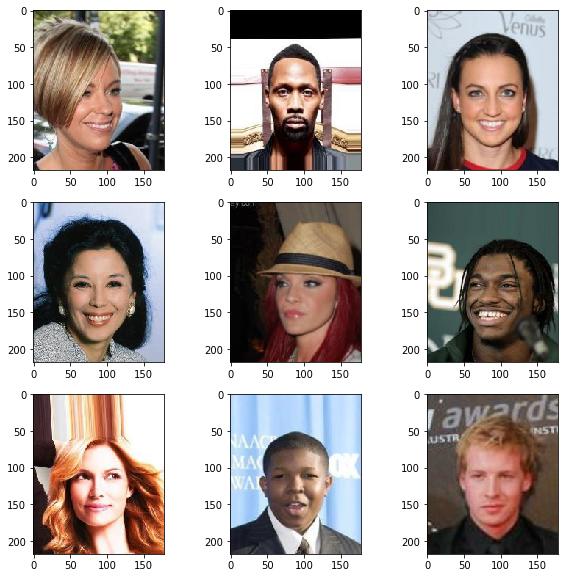

In [93]:
# view first 9 images
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for i, path in enumerate(image_paths_sliced[:9]):
    img = tf.keras.preprocessing.image.load_img(path)
    plt.subplot(3,3,i+1)
    plt.imshow(img)
plt.show()

In [94]:
def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  # If the value is an eager tensor BytesList won't unpack a string from an EagerTensor.
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() 
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [95]:
def serialize_example(image, label, image_shape):
    feature = {
        'image': _bytes_feature(image),
        'label': _bytes_feature(label),
        'height': _int64_feature(image_shape[0]),
        'width': _int64_feature(image_shape[1]),
        'depth': _int64_feature(image_shape[2]),
    }

    #  Create a Features message using tf.train.Example.

    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()

In [96]:
from PIL import Image 

In [25]:
# TESTING
# NO NEED TO RUN
#Split ImagePath and labels into 10
import numpy as np
split = 50
num_images = 100
jump = int(num_images/split)
split_arr = np.linspace(0,num_images,split+1)
print(split_arr)

[  0.   2.   4.   6.   8.  10.  12.  14.  16.  18.  20.  22.  24.  26.
  28.  30.  32.  34.  36.  38.  40.  42.  44.  46.  48.  50.  52.  54.
  56.  58.  60.  62.  64.  66.  68.  70.  72.  74.  76.  78.  80.  82.
  84.  86.  88.  90.  92.  94.  96.  98. 100.]


In [26]:
my_data_sliced.shape

(202599, 40)

In [97]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

In [98]:
# Split into 10 TfRecords
tfrecord_dir = 'TfRecords_28_28_1_Zoom/data_{}.tfrecords'
labels = my_data_sliced;
file_index_count = 0

file_limit = 7
split_arr = np.linspace(0,num_images,file_limit+1)
i = 0;
for index in range(file_limit):
    print(i)
    with tf.io.TFRecordWriter(tfrecord_dir.format(file_index_count)) as writer:
        labels = my_data_sliced[int(split_arr[i]):int(split_arr[i+1]),:]
        image_paths_sliced2 = image_paths_sliced[int(split_arr[i]):int(split_arr[i+1])]
        for image_path, label in zip(image_paths_sliced2, labels):
            img = tf.keras.preprocessing.image.load_img(image_path)
            # PIL format
            # Resize below 218,176
            img = img.resize((28,28))
            #print(img_array.shape)
            # RGB to grayscale here
            
            img_array = tf.keras.preprocessing.image.img_to_array(img)
            # Numpy Format
            img_array = rgb2gray(img_array)
            
            
            #print(img_array.shape)
            img_array=img_array.reshape(28,28,1)
            #img_array = tf.expand_dims(img_array, axis=2)
            # tf format
            #print(img_array.shape)
            #print(img_array[0])
            #img_array=tf.make_ndarray(img_array)
            img_array=img_array.astype('float32')
            
            #np format
            
            # Preprocessing if desrired
            img_array = tf.keras.preprocessing.image.random_zoom(img_array, (0.5,0.5),
                                                    row_axis=0,col_axis=1,channel_axis=2)
        
            img_bytes = tf.io.serialize_tensor(img_array)
            label = tf.io.serialize_tensor(label)
            image_shape = img_array.shape
    
            example = serialize_example(img_bytes, label, image_shape)
            writer.write(example)
            
        file_index_count += 1
        i+=1

0
1
2
3
4
5
6


In [88]:
def read_tfrecord(serialized_example):
    feature_description = {
        'image': tf.io.FixedLenFeature((), tf.string),
        'label': tf.io.FixedLenFeature((), tf.string),
        'height': tf.io.FixedLenFeature((), tf.int64),
        'width': tf.io.FixedLenFeature((), tf.int64),
        'depth': tf.io.FixedLenFeature((), tf.int64)
    }

    example = tf.io.parse_single_example(serialized_example, feature_description)
    
    image = tf.io.parse_tensor(example['image'], out_type = float)
    label = tf.io.parse_tensor(example['label'], out_type = float)
    image_shape = [example['height'], example['width'], example['depth']]
    image = tf.reshape(image, image_shape)
    
    return (image, example['label'])


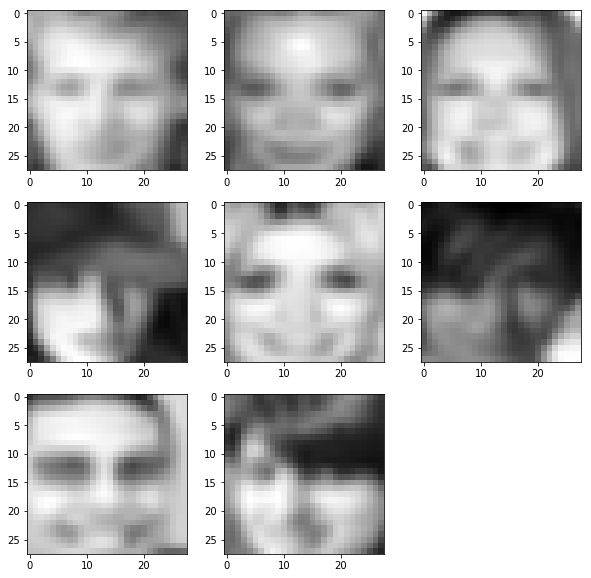

In [89]:
tfrecord_dir = 'TfRecords_28_28_1_Zoom/data_1.tfrecords'

tfrecord_dataset = tf.data.TFRecordDataset(tfrecord_dir)
parsed_dataset = tfrecord_dataset.map(read_tfrecord)


plt.figure(figsize=(10,10))

for i,data in enumerate(parsed_dataset.take(8)):
    img = data
    img = tf.keras.preprocessing.image.array_to_img(data[0])
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
   
plt.show()

In [71]:
# Labels

for i, data in enumerate(parsed_dataset.take(9)):
    label = data[1]
    label = tf.io.parse_tensor(label,out_type = tf.float64)
    print(label)

tf.Tensor(
[-1.  1.  1. -1. -1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
  1.  1. -1.  1. -1. -1.  1.  1. -1.  1. -1.  1. -1.  1. -1. -1.  1. -1.
  1. -1. -1.  1.], shape=(40,), dtype=float64)
tf.Tensor(
[-1. -1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
  1.  1. -1. -1. -1. -1.  1. -1. -1. -1. -1. -1. -1. -1. -1.  1. -1. -1.
  1. -1. -1.  1.], shape=(40,), dtype=float64)
tf.Tensor(
[-1. -1.  1. -1. -1. -1. -1. -1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1.  1. -1. -1.  1. -1. -1. -1. -1. -1. -1.  1. -1. -1. -1. -1.
 -1. -1. -1.  1.], shape=(40,), dtype=float64)
tf.Tensor(
[-1. -1.  1.  1. -1. -1. -1. -1.  1. -1. -1. -1.  1. -1. -1. -1. -1. -1.
 -1.  1.  1.  1. -1. -1.  1.  1. -1. -1. -1. -1. -1.  1.  1. -1. -1. -1.
 -1. -1. -1.  1.], shape=(40,), dtype=float64)
tf.Tensor(
[-1. -1. -1. -1. -1. -1. -1. -1. -1.  1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1.  1.  1.  1. -1. -1.  1.  1. -1. -1. -1. -1. -1.  1.  1. -1. -1. -1.
 -1. -1. -1.  1.], shape=(4